In [1]:
import torch

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [2]:
from torchvision import transforms, datasets, utils

transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
BATCH_SIZE = 64

train_dataset = datasets.MNIST(root = '../data',
                                         train = True,
                                         download = True,
                                         transform = transform_MNIST)

test_dataset = datasets.MNIST(root = '../data',
                                train = False,
                                download = True,
                                transform = transform_MNIST)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
import torch.nn as nn
from torchsummary import summary

class Custom_CNN(nn.Module):
    def __init__(self):
        super(Custom_CNN, self).__init__()

        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool2d(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2d(x)
        x = x.view(-1,320)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model = Custom_CNN().to(DEVICE)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
              ReLU-2           [-1, 10, 24, 24]               0
         MaxPool2d-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
              ReLU-5             [-1, 20, 8, 8]               0
         MaxPool2d-6             [-1, 20, 4, 4]               0
            Linear-7                   [-1, 50]          16,050
              ReLU-8                   [-1, 50]               0
            Linear-9                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.08
Estimated Total Size (MB): 0.21
---------------------------------------------

In [5]:
import torch.optim as optim

LR = 0.0001

optimizer = optim.Adam(model.parameters(), lr=LR)

In [6]:
import torch.nn.functional as F

def train_one_epoch(model, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy

In [7]:
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    train_one_epoch(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303087
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.614790
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.721913
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.247139
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.432756
[1] Test Loss: 0.2876, Accuracy: 91.78%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.280064
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.224307
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.273501
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.184847
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.166753
[2] Test Loss: 0.1766, Accuracy: 94.80%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.238061
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.182337
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.075542
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.228908
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.126814
[3] Test Loss: 0.1293, Accuracy: 96.31%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.227974
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.121940
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.194603


In [8]:
CLASSES = dict()

for i in range(10) :
    CLASSES[i] = train_dataset.classes[i]

print(CLASSES)

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


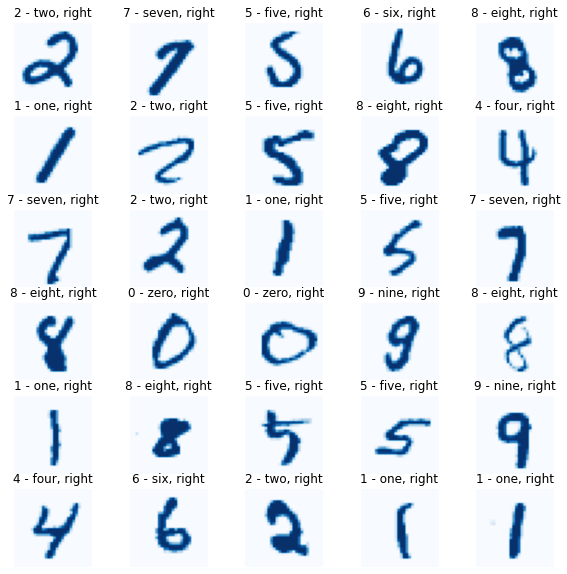

In [9]:
import numpy as np
import matplotlib.pyplot as plt

columns = 6
rows = 5
fig = plt.figure(figsize=(10,10))
model.eval()

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(DEVICE)
    output = model(input_img)
    _, argmax = torch.max(output, dim=1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[test_dataset[data_idx][1]]
    
    fig.add_subplot(columns, rows, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show() 